In [10]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

In [11]:
# Offline changepoint detection
def changepoint_detection(data, hazard_function, distribution):
    length = len(data)
    H = hazard_function(np.arange(length + 1))
    Pr = np.zeros((length + 1, length + 1))    # length + 1 b/c 0 is for priors
    # Pr[r, t] = P(r_t=r, x_1:t)

    Pr[0, 0] = 1
    for t, x in enumerate(data):
        t += 1    # t=0 is for priors stuff. First data point is @ t=1
        predprobs = distribution.pdf(x)
        Pr[1:t + 1, t] = Pr[:t, t - 1] * predprobs * (1 - H[:t])
        Pr[0, t] = np.sum(Pr[:t, t - 1] * predprobs * H[:t])
        Pr[:, t] /= np.sum(Pr[:, t])    # normalize probabilities
        distribution.update(x)
    return Pr

In [12]:
class BayesianChangepointDetection(object):
    def __init__(self, hazard, distribution):
        self.hazard = hazard
        self.distribution = distribution
        self.time = 0
    
        self.Pr = np.ones(1)
    
    def step(self, x):
        self.time += 1

        H = self.hazard(np.arange(self.time))
        old = self.Pr
        self.Pr = np.zeros(self.time + 1)   # +1 because 0 <= r <= time
        
        predprob = self.distribution.pdf(x)
        self.distribution.update(x)
        
        self.Pr[1:] = old * predprob * (1 - H)
        self.Pr[0] = np.sum(old * predprob * H)
        self.Pr /= np.sum(self.Pr)
        
        return self.Pr

In [13]:
class Distribution(object):
    
    def __init__(self):
        self.kappa = 0
        self.mu = 0
        
    def pdf(self, data):
        return 1
    
    def update(self, data):
        kappa_update = self.kappa + 1.
        mu_update = (self.kappa * self.mu + data) / (self.kappa + 1)
        
        self.kappa = kappa_update
        self.mu = mu_update

In [5]:
class Gaussian(Distribution):
    """ Adapted from
        http://engineering.richrelevance.com/
            bayesian-analysis-of-normal-distributions-with-python/,
        http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    
    def __init__(self, kappa, mu, alpha, beta):
        # Certainty about mean
        self.kappa = kappa
        # Estimation of Mean
        self.mu = mu
        # Estimation of Variance
        # Paramater for Gamma Distribution
        self.alpha = alpha
        # Sum of Squares
        self.beta = beta
    
    def pdf(self, data):
        return stats.norm.pdf(x = data,
                              loc = self.mu,
                              scale = np.sqrt(self.beta / self.kappa))
    
    def update(self, data):
        # Update Confidence
        kappa_update = self.kappa + 1.
        # Update Mean
        mu_update = (self.kappa * self.mu + data) / (self.kappa + 1)
        # Update Variance
        alpha_update = self.alpha + .5
        beta_update = self.beta + (self.kappa * (data - self.mu)**2) / (2. * (self.kappa + 1.))
        
        self.kappa = kappa_update
        self.mu = mu_update
        self.alpha = alpha_update
        self.beta = beta_update

In [18]:
class StudentT(Distribution):
    """ Taken from https://github.com/hildensia/bayesian_changepoint_detection
        Adapted to remove concatenation and standardize style
    """
    def __init__(self, kappa, mu, alpha, beta):
        self.kappa = kappa
        self.mu = mu
        self.alpha = alpha
        self.beta = beta

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update(self, data):
        kappa_update = self.kappa + 1.
        mu_update = (self.kappa * self.mu + data) / (self.kappa + 1)
        alpha_update = self.alpha + 0.5
        beta_update = self.beta + (self.kappa * (data - self.mu)**2) / (2. * (self.kappa + 1.))
         
        self.kappa = kappa_update
        self.mu = mu_update
        self.alpha = alpha_update
        self.beta = beta_update

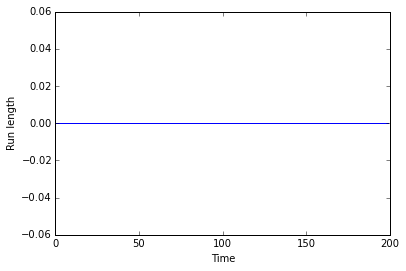

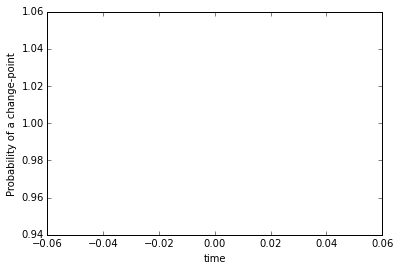

In [25]:
#Run Detection on Gaussian Distribution
data = [0] * 100 + [1] * 100
def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t
Pr = changepoint_detection(data, hazard, Gaussian(0.1, 0.1, 1, 0))

plt.plot([Pr[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([Pr[0, t] for t in range(len(data))])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

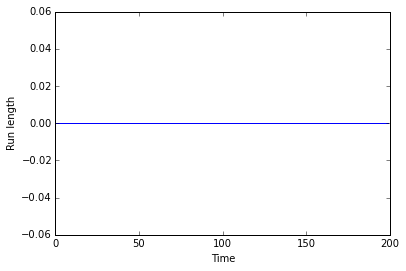

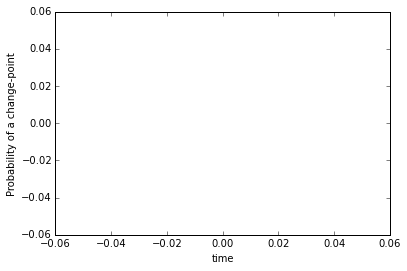

In [27]:
data = [0] * 100 + [1] * 100
def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

detector = BayesianChangepointDetection(hazard, Gaussian(0.1, 0.1, 1, 0))

Pr = [detector.step(x) for x in data]

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([pr[0] for pr in Pr])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

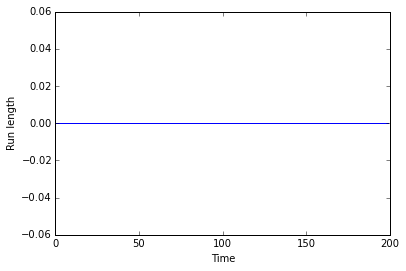

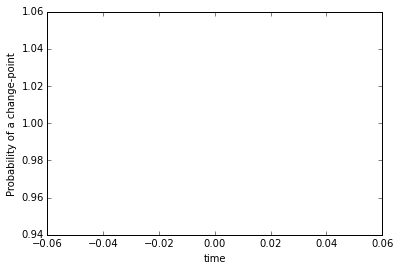

In [28]:
data = [0] * 100 + [1] * 100
def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t
Pr = changepoint_detection(data, hazard, StudentT(0.1, 0.1, 1, 0))

plt.plot([Pr[:, t].argmax() for t in range(len(data))])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([Pr[0, t] for t in range(len(data))])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()

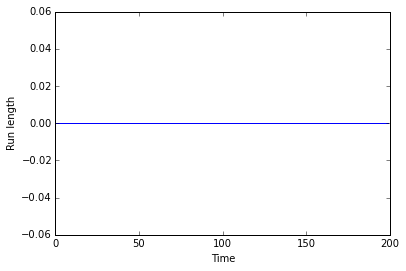

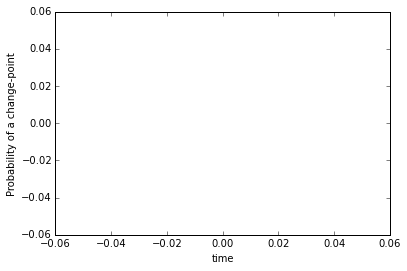

In [29]:
data = [0] * 100 + [1] * 100
def hazard(t):
    # given run length, return Pr(run is over)
    p = 0.6
    return p * (1-p) ** t

detector = BayesianChangepointDetection(hazard, StudentT(0.1, 0.1, 1, 0))

Pr = [detector.step(x) for x in data]

plt.plot([pr.argmax() for pr in Pr])
plt.xlabel("Time")
plt.ylabel("Run length")
plt.show()

plt.plot([pr[0] for pr in Pr])
plt.xlabel("time")
plt.ylabel("Probability of a change-point")
plt.show()